In [1]:
import tensorflow.examples.tutorials.mnist.input_data as input_data

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt 
%matplotlib inline

import time
import os
import glob

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
y = mnist.train.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


* show model names and noise factors

In [3]:
models = ['l0_rvae','l0_rvae2','l0_rvae3']
noise_factors = [0.0,0.2,0.4]

* structure of rvae: 

rvae: 512 --> 384 --> 256 --> 5 --> 256 --> 384 --> 512 with activation function tf.nn.elu

rvae2: 512 --> 384 --> 256 --> 49 --> 256 --> 384 --> 512 with activation function tf.nn.elu 

rvae3: 784 --> 196 --> 49 --> 196 --> 784 with tf.nn.sigmoid

* structure of dae:

784 --> 196 --> 49 --> 196 --> 784 following Chong's paper with tf.sigmoid


## Total loss of X = L + S

In [4]:
models_errors = {}
for i in range(len(models)):
    tmp={}
    for j in range(len(noise_factors)):
        path = "save_images_"+models[i]+"/"+str(noise_factors[j])+"/*_errors.npy"
        tmp[noise_factors[j]] = np.load(glob.glob(path)[0])
    models_errors[models[i]]=tmp
# models_errors

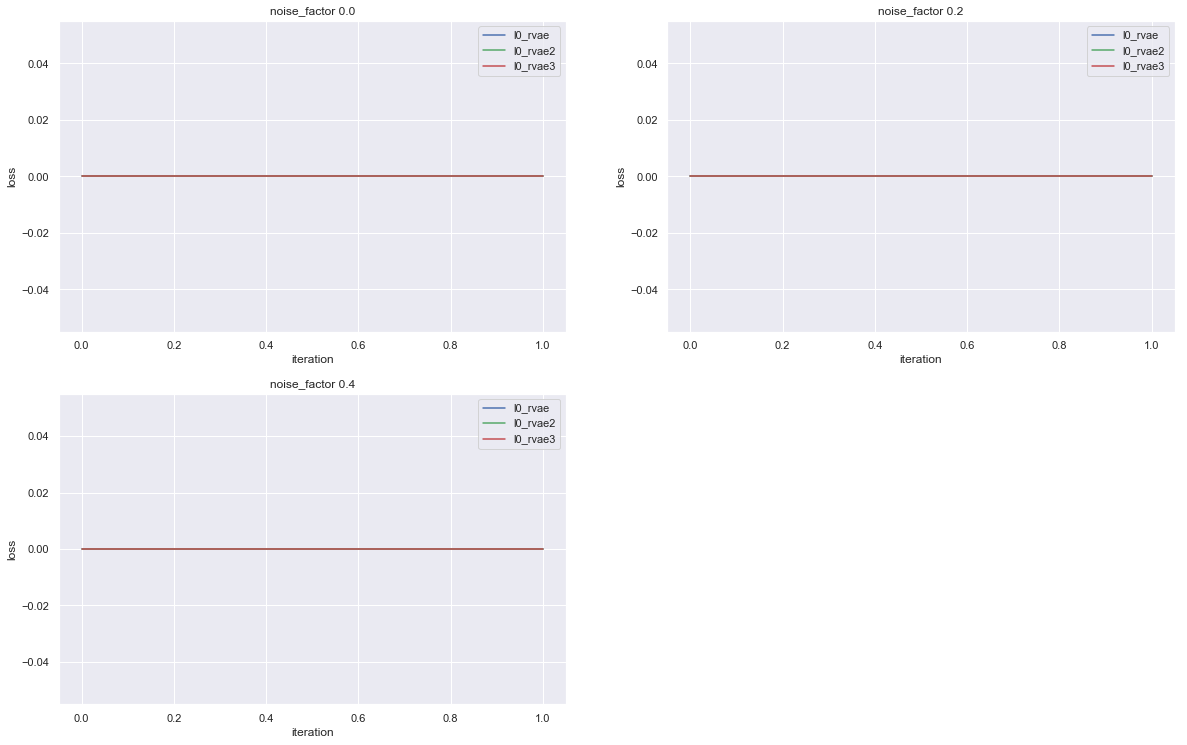

In [5]:
colors=['b','g','r','c','m','y','w','k']
plt.figure(figsize=(20, 40))
for index,key in enumerate(sorted(models_errors[models[0]].keys())):
    for i in range(len(models)):
        plt.subplot(6, 2, index+1)
        x_axis = np.arange(len(models_errors[models[i]][key]))
        plt.plot(x_axis, models_errors[models[i]][key],color = colors[i],label = models[i])
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.title("noise_factor "+str(key))
        plt.legend()
plt.show()

## Denoising

### Test denoising --> RF accuracy
A higher accuracy means a better result of denoising

In [6]:
def test_denoising_acc(X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    
    clf = RandomForestClassifier(n_estimators=50, max_depth=2, random_state=595)
    clf.fit(X_train, y_train)
    
    return clf.score(X_test, y_test)

In [7]:
models_acc = {}
for i in range(len(models)):
    tmp = {}
    for j in range(len(noise_factors)):
        path = 'save_images_'+models[i]+"/"+str(noise_factors[j])+"/*_transform.npy"
        test_acc = test_denoising_acc(np.load(glob.glob(path)[0]))
        tmp[noise_factors[j]] = test_acc
    models_acc[models[i]] = tmp
models_acc

{'l0_rvae': {0.0: 0.61069090909090906, 0.2: 0.6472, 0.4: 0.54130909090909096},
 'l0_rvae2': {0.0: 0.5798545454545454,
  0.2: 0.54232727272727277,
  0.4: 0.55163636363636359},
 'l0_rvae3': {0.0: 0.38116363636363637,
  0.2: 0.27927272727272728,
  0.4: 0.28807272727272726}}

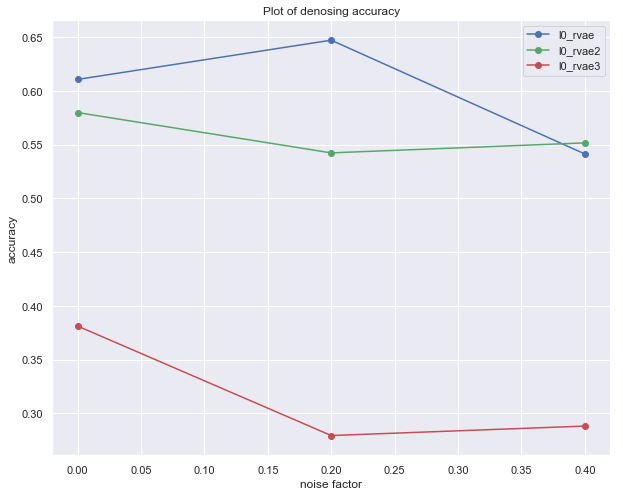

In [8]:
colors=['b','g','r','c','m','y','w','k']
plt.figure(figsize=(10, 8))   
for k in range(len(models)):
    plt.plot(noise_factors, list(dict(sorted(models_acc[models[k]].items())).values()), 
             color = colors[k],marker = 'o',label=models[k])

plt.xlabel('noise factor')
plt.ylabel('accuracy')
plt.legend()
plt.title('Plot of denosing accuracy')
plt.show()

### Generate 100 reconstruction images after final training

In [9]:
models_recon = {}
for i in range(len(models)):
    tmp = {}
    for j in range(len(noise_factors)):
        path = 'save_images_'+models[i]+"/"+str(noise_factors[j])+"/*_recon.npy"
        recon = np.load(glob.glob(path)[0])
        tmp[noise_factors[j]] = recon[:100] #only reconstruct first 100 images
    models_recon[models[i]] = tmp
# models_recon

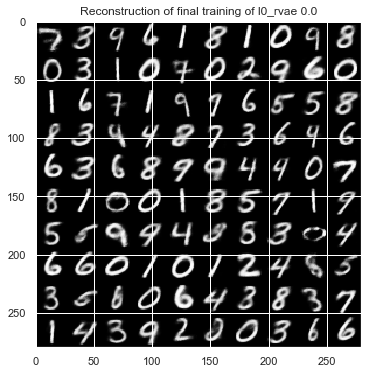

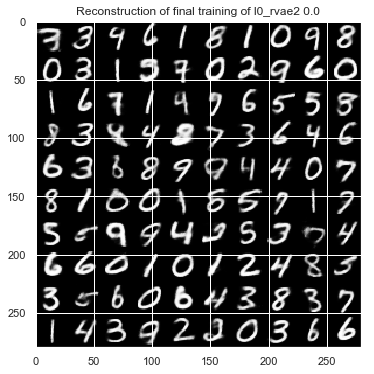

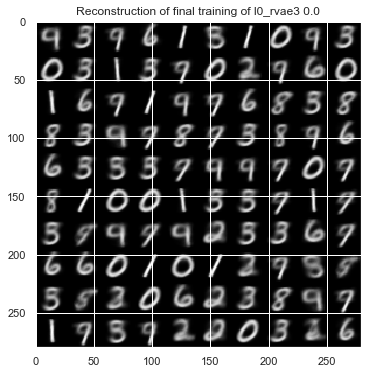

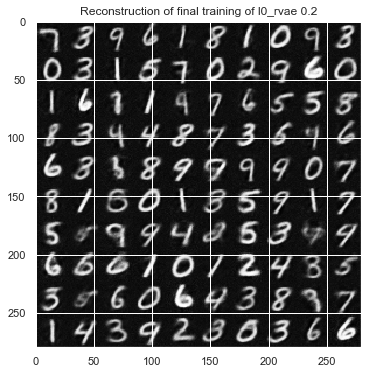

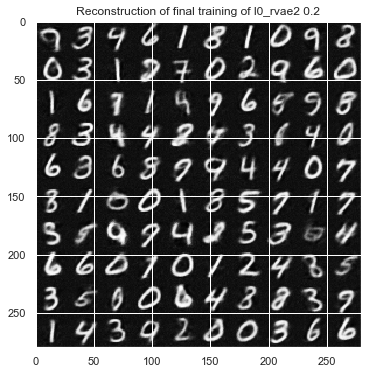

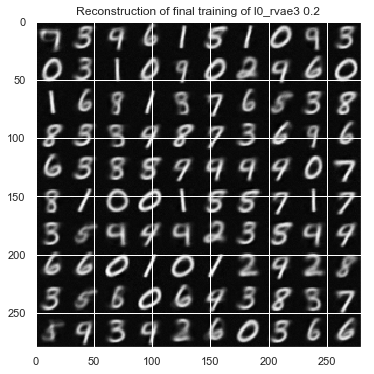

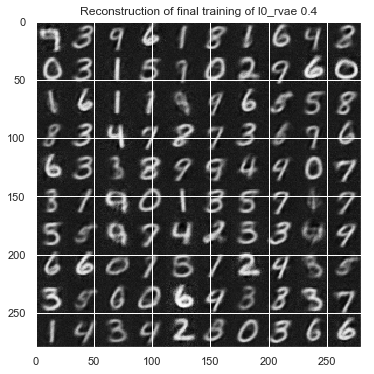

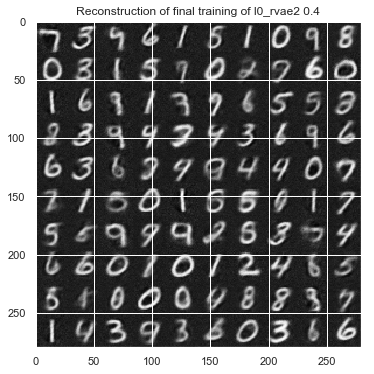

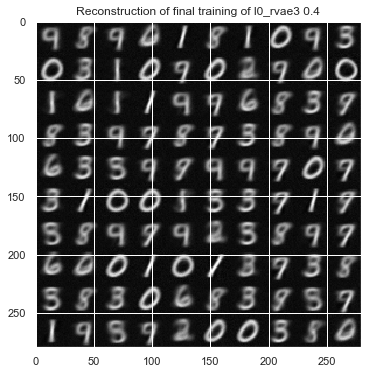

In [10]:
h = w = 28
num_gen = 100

for index,key in enumerate(sorted(models_recon[models[0]].keys())):
    for k in range(len(models)):
        n = np.sqrt(num_gen).astype(np.int32)
        I_generated = np.empty((h*n, w*n))
        rvae_generated = models_recon[models[k]][key]
        for i in range(n):
            for j in range(n):
                I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = rvae_generated[i*n+j, :].reshape(28, 28)

        plt.figure(figsize=(6, 6))
        plt.title("Reconstruction of final training of "+models[k]+" "+ str(key))
        plt.imshow(I_generated, cmap='gray')
        plt.show()

## Generation

### GIF for generation

In [11]:
import imageio

In [12]:
for i in range(len(models)):
    for j in range(len(noise_factors)):
        path = 'save_images_'+models[i]+"/"+str(noise_factors[j])+"/generator*"
        file_list = glob.glob(path)
        list.sort(file_list, key=lambda x: int(x.split('_')[-1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case

        images = []
        for filename in file_list:
            images.append(imageio.imread(filename))
        
        save_path = 'save_images_'+models[i]+"/"+"generator_gifs/"
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        imageio.mimsave(save_path+str(noise_factors[j])+'.gif', images)


### GIF for reconstruction

In [13]:
for i in range(len(models)):
    for j in range(len(noise_factors)):
        path = 'save_images_'+models[i]+"/"+str(noise_factors[j])+"/reconstructor*"
        file_list = glob.glob(path)
        list.sort(file_list, key=lambda x: int(x.split('_')[-1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case

        images = []
        for filename in file_list:
            images.append(imageio.imread(filename))
        
        save_path = 'save_images_'+models[i]+"/"+"reconstructor_gifs/"
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        imageio.mimsave(save_path+str(noise_factors[j])+'.gif', images)


### Show Autoencoders loss

* Extract last epoch's loss of each iteration of autoencoders

To see if the bad results because of autoencoders

In [14]:
models_autoencoder_loss = {}
for i in range(len(models)):
    tmp = {}
    for j in range(len(noise_factors)):
        path = 'save_images_'+models[i]+"/"+str(noise_factors[j])+"/*_loss*.npy"
        file_list = glob.glob(path)
        list.sort(file_list, key=lambda x: int(x.split('_')[-1].split('loss')[1].split('.npy')[0]))
        loss = []
        for f in file_list:
             loss.append(np.load(f)[-1])
        tmp[noise_factors[j]] = loss #only reconstruct first 100 images
    models_autoencoder_loss[models[i]] = tmp
# models_autoencoder_loss

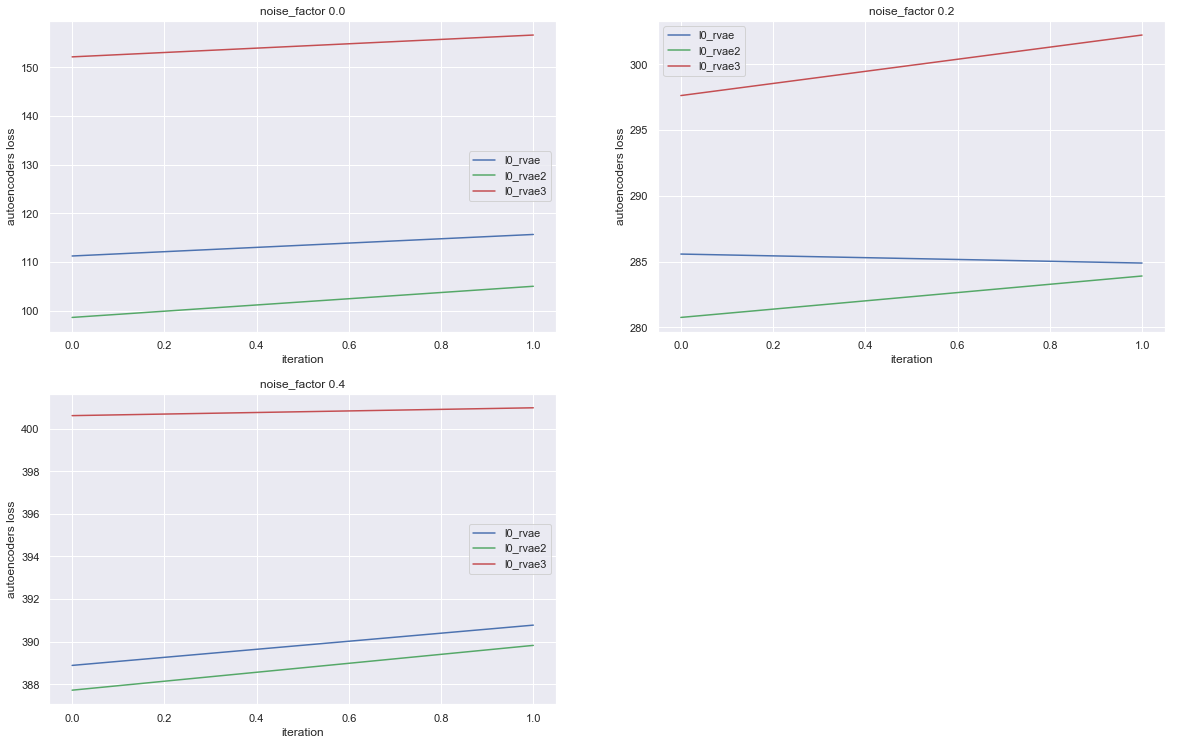

In [15]:
colors=['b','g','r','c','m','y','w','k']
plt.figure(figsize=(20, 40))
for index,key in enumerate(sorted(models_autoencoder_loss[models[0]].keys())):
    for i in range(len(models)):
        plt.subplot(6, 2, index+1)
        x_axis = np.arange(len(models_autoencoder_loss[models[i]][key]))
        plt.plot(x_axis, models_autoencoder_loss[models[i]][key],color = colors[i],label = models[i])
        j = j+1
        plt.xlabel('iteration')
        plt.ylabel('autoencoders loss')
        plt.title("noise_factor "+str(key))
        plt.legend()
plt.show()